In [264]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
import sys
import swifter
# Vectorizer for dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])
# nlp.Defaults.stop_words.add("roll")
nlp.Defaults.stop_words |= {"roll","look","know", "going"}
sns.set_theme()

In [2]:
def wordcloud(text):
  wordcloud = WordCloud(background_color="white").generate(text)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")

In [276]:
# Abertura dos arquivos
podcast_file = open('data/general_podcasts.csv', mode='r')
skills_file = open('data/skills_dataset.csv', mode='r')
CR_file = open('data/CR_skills_dataset.csv', mode='r')

In [302]:
skill_list = ['acrobatics',
 'animal handling',
 'arcana',
 'athletics',
 'deception',
 'history',
 'insight',
 'intimidation',
 'investigation',
 'medicine',
 'nature',
 'performance',
 'persuasion',
 'religion',
 'sleight of hand',
 'stealth',
 'survival']

In [274]:
valid_columns = ["skill", "backward_text"]

In [275]:
podcast_file_df = pd.read_csv(podcast_file, usecols=valid_columns)

EmptyDataError: No columns to parse from file

In [7]:
skills_file_df = pd.read_csv(skills_file, usecols=valid_columns)

In [8]:
CR_file_df = pd.read_csv(CR_file, usecols=valid_columns)

In [9]:
podcast_file_df = podcast_file_df.loc[podcast_file_df["skill"].str.lower().isin(skill_list)]

In [10]:
len(podcast_file_df)

1729

In [11]:
len(CR_file_df)

5254

In [12]:
len(CR_file_df.loc[CR_file_df["skill"].str.lower().isin(skill_list)])

5254

In [13]:
len(skills_file_df)

49805

In [14]:
skills_file_df = skills_file_df.loc[skills_file_df["skill"].str.lower().isin(skill_list)]

In [15]:
len(skills_file_df)

7633

In [29]:
concatenated_df = pd.concat([podcast_file_df, skills_file_df, CR_file_df], ignore_index=True)

In [17]:
len(concatenated_df)

14616

In [31]:
concatenated_df['skill'] = concatenated_df['skill'].apply(lambda x: x.lower())
concatenated_df

,skill,backward_text
0,perception,going weekly for the rest of the experimental ...
1,performance,"by, like, logic, you know what I mean? So I ca..."
2,investigation,"success, you open yourself up to repercussions..."
3,insight,"success, you open yourself up to repercussions..."
4,perception,play in the NFL!” and he was like “No.” There’...
...,...,...
14611,investigation,(laughter) (sings) Continuity. Roll for contin...
14612,insight,"wall. There is a very, very faint scratch into..."
14613,deception,advice from when it comes to administrating my...
14614,stealth,I was under the assumption that you had to be ...


In [21]:
concatenated_df["backward_text"][4]

'play in the NFL!” and he was like “No.” There’s some really- we haven’t— I really like this idea of a Chosen that’s just like [crosstalk] “No, no thank you!”'

In [23]:
def filter_functions(text):
    splited_text = [i.strip('-?!:') for i in text.split(' ')]
    joined_text = ' '.join(splited_text)
    return joined_text

In [74]:
def filter_irrelevant_words(phrase):
    filtered_phrase = filter_functions(phrase)
    doc = nlp(filtered_phrase)
    word_list = []
    for token in doc:
        if not token.is_stop and token.pos_ in ("VERB", "NOUN") and len(token.shape_) > 2:
            filtered_text = token.text
            word_list.append(token.text)
#             pd.Series(x).apply(lambda x: x.strip('-?!:')).to_numpy()
    
    return word_list

In [75]:
%time doc = nlp(concatenated_df["backward_text"][4].lower())
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)
filter_irrelevant_words(concatenated_df["backward_text"][4])


CPU times: user 7.14 ms, sys: 16 µs, total: 7.16 ms
Wall time: 6.12 ms
play play VERB  xxxx True False
in in ADP  xx True True
the the DET  xxx True True
nfl nfl NOUN  xxx True False
! ! PUNCT  ! False False
” " PUNCT  ” False False
and and CCONJ  xxx True True
he he PRON  xx True True
was be VERB  xxx True True
like like ADP  xxxx True False
“ " PUNCT  “ False False
no no INTJ  xx True True
. . PUNCT  . False False
” " PUNCT  ” False False
there there PRON  xxxx True True
’s ’ VERB  ’x False True
some some DET  xxxx True True
really- really- NOUN  xxxx- False False
we we PRON  xx True True
have have VERB  xxxx True True
n’t n’t PART  x’x False True
— — PUNCT  — False False
i I PRON  x True True
really really ADV  xxxx True True
like like VERB  xxxx True False
this this DET  xxxx True True
idea idea NOUN  xxxx True False
of of ADP  xx True True
a a DET  x True True
chosen choose VERB  xxxx True False
that that DET  xxxx True True
’s ’ VERB  ’x False True
just just ADV  xxxx True True
l

['play', 'nfl', 'like', 'idea', 'chosen', 'crosstalk', 'thank']

In [76]:
# concatenated_df['backward_text'] = [re.sub('[^A-Za-z0-9]+', ' ', i).lower() for i in concatenated_df["backward_text"]]
concatenated_df['backward_text'] = [i.lower() for i in concatenated_df["backward_text"]]
concatenated_df

,skill,backward_text,filtered_words
0,perception,going weekly for the rest of the experimental ...,"[going, rest, arcs, starting, week, guess, epi..."
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, know, mean, wanna, help, inhaling, tee..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
4,perception,play in the nfl!” and he was like “no.” there’...,"[play, nfl, like, idea, chosen, crosstalk, thank]"
...,...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."
14614,stealth,i was under the assumption that you had to be ...,"[assumption, rolo, level, bath, house, house, ..."


In [239]:
%time concatenated_df["filtered_words"] = concatenated_df["backward_text"].swifter.apply(filter_irrelevant_words)

Pandas Apply:   0%|          | 0/14616 [00:00<?, ?it/s]

CPU times: user 1min 43s, sys: 311 ms, total: 1min 43s
Wall time: 1min 43s


In [240]:
concatenated_df

,skill,backward_text,filtered_words
0,perception,going weekly for the rest of the experimental ...,"[rest, arcs, starting, week, guess, episode, h..."
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
4,perception,play in the nfl!” and he was like “no.” there’...,"[play, nfl, like, idea, chosen, crosstalk, thank]"
...,...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."
14614,stealth,i was under the assumption that you had to be ...,"[assumption, rolo, level, bath, house, house, ..."


In [229]:
def nlp_vs_ordinary(df):
    backward_text_df = df.groupby('skill')['backward_text'].apply(lambda x: [str(x).split(' ') for i in x])
    backward_text_df = backward_text_df.apply(lambda x: [item for sublist in x for item in sublist if item])
#     backward_text_df = [x for x in backward_text_df if x]
    filtered_words_df = df.groupby('skill')['filtered_words'].apply(lambda x: [item for sublist in x for item in sublist])
#     backward_text = df['backward_text'].to_numpy().flatten()
#     filtered_words = df['filtered_words'].to_numpy().flatten()
#     fig, axs = plt.subplots(ncols=2)
#     plot = sns.barplot(x="quantidade",y=filtered_words_df['skill']['filtered_words'], data=filtered_words_df)
    for i in skill_list:
        bar_graphic_vs(backward_text_df[i], filtered_words_df[i], title=i)
#     bar_graphic(lista=filtered_words_df['acrobatics'], pos=1)
#         backward_text_dict = ocorrencias(backward_text_df[i])
#         filtered_words_dict = ocorrencias(filtered_words_df[i])
#         sns.barplot(x=backward_text_df[i], data=backward_text_df[i])
#         sns.barplot(x='value', y='wage', data=df_melt, ax=axs[0])
#         sns.barplot(x='value', y='wage', data=df_melt, ax=axs[1])
#         sns.barplot()

#     print(filtered_words_df.index)


#     ## Wordcloud
#     for i in skill_list:
#         wordcloud(' '.join(backward_text_groupby[i]))
#         wordcloud(' '.join(filtered_words_groupby[i]))
 
#     print(backward_text_df)

In [144]:
"""
    Função que transforma uma lista de palavras bem formatadas em um dicionário de ocorrências.
    Ex.:
        > x = ['Philipe', 'Jc', 'Victor', 'Philipe', 'Jc', 'Victor', 'Victor', 'Jc']
        > ocorrencias(x)
        > {'Philipe': 2, 'Jc': 3, 'Victor': 3}
"""
def ocorrencias(lista):
    dict_ocorrencias = {}
    for i in lista:
        if i in dict_ocorrencias:
            dict_ocorrencias[i] += 1
        else:
            dict_ocorrencias[i] = 1
    return dict_ocorrencias

In [209]:
"""
    Função que dado um dicionário de ocorrências ou lista bem formatada,
    plota um gráfico com as palavras com maior ocorrência (15 por padrão).
"""
def bar_graphic(dicionario=None, paleta="rocket", lista = None, max=15, dim=(12,9), title=None, pos=0):
    # Se não tiver dicionario, vai ter uma lista
    if dicionario is None:
        if lista is not None:
            # A lista é então convertida para dicionario através da função de ocorrencias
            dicionario = ocorrencias(lista)
    
    # O dicionario é transformado em dataframe para melhor manipulação
    df = pd.DataFrame(dicionario.items(), columns=["key", "value"])
    # Dataframe ordenado de forma decrescente e com o máximo estipulado
    df = df.sort_values(by="value", ascending=False).head(max)
    
    # É então re-convertido em dicionario
    top_dicionario = dict(df.values)
    
    # As chaves e valores são convertidas em lista para auxiliar na plotagem do gráfico
    palavras = list(top_dicionario.keys())
    valores = list(top_dicionario.values())

    ## Plot
    # Define dimensões para o gráfico
    fig_dims = dim
    fig, axs = plt.subplots(figsize=fig_dims, ncols=2)
    # Configura o eixo, paleta e dimensões do gráfico
    plot = sns.barplot(x=palavras,y=valores, palette=paleta, ax=axs[pos])
    # Define o título do gráfico
    if title is None:
        plt.title(f'Top {max} Ocorrências')
    else:
        plt.title(title)
    # Rotaciona a legenda de cada barra e plota o gráfico
    plt.setp(plot.get_xticklabels(), rotation=45)

In [231]:
"""
    Função que dado um dicionário de ocorrências ou lista bem formatada,
    plota um gráfico com as palavras com maior ocorrência (15 por padrão).
"""
def bar_graphic_vs(lista1, lista2, max=15, dim=(14,7), title=None, pos=0):
    dicionario1 = ocorrencias(lista1)
    dicionario2 = ocorrencias(lista2)
    # O dicionario é transformado em dataframe para melhor manipulação
    df1 = pd.DataFrame(dicionario1.items(), columns=["key", "value"])
    df2 = pd.DataFrame(dicionario2.items(), columns=["key", "value"])
    # Dataframe ordenado de forma decrescente e com o máximo estipulado
    df1 = df1.sort_values(by="value", ascending=False).head(max)
    df2 = df2.sort_values(by="value", ascending=False).head(max)
    # É então re-convertido em dicionario
    top_dicionario1 = dict(df1.values)
    top_dicionario2 = dict(df2.values)
    # As chaves e valores são convertidas em lista para auxiliar na plotagem do gráfico
    palavras1 = list(top_dicionario1.keys())
    palavras2 = list(top_dicionario2.keys())
    
    valores1 = list(top_dicionario1.values())
    valores2 = list(top_dicionario2.values())

    ## Plot
    # Define dimensões para o gráfico
    fig_dims = dim
    fig, axs = plt.subplots(figsize=fig_dims, ncols=2)
    # Configura o eixo, paleta e dimensões do gráfico
    plot = sns.barplot(x=palavras1,y=valores1, ax=axs[0])
    plot2 = sns.barplot(x=palavras2,y=valores2, ax=axs[1])
    # Define o título do gráfico
    plt.title(title)
    # Rotaciona a legenda de cada barra e plota o gráfico
    plt.setp(plot.get_xticklabels(), rotation=45)
    plt.setp(plot2.get_xticklabels(), rotation=45)
    

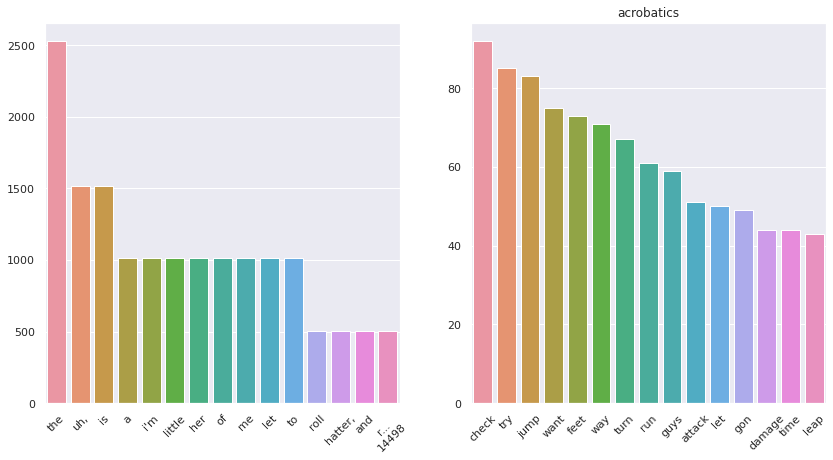

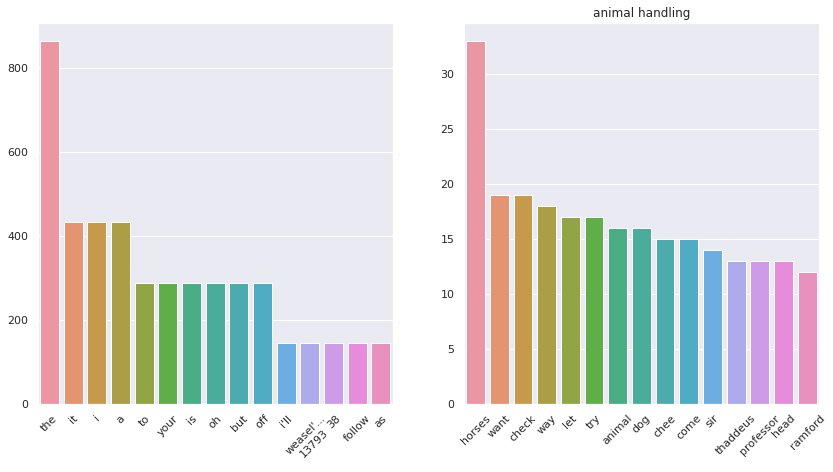

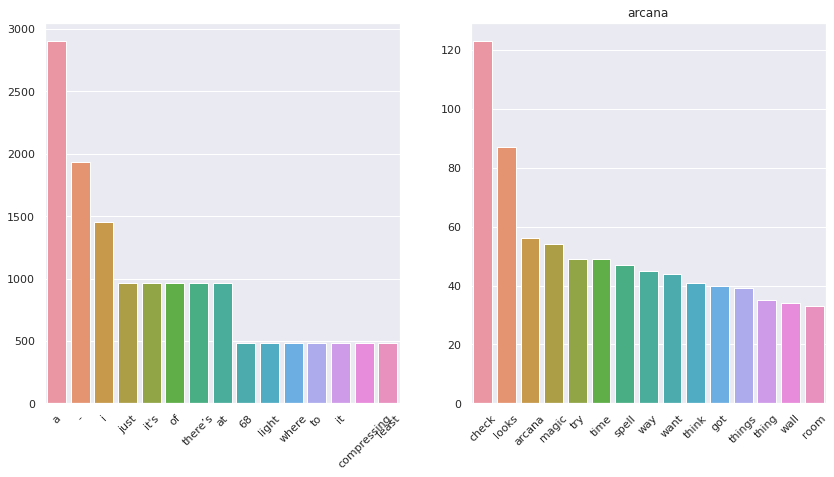

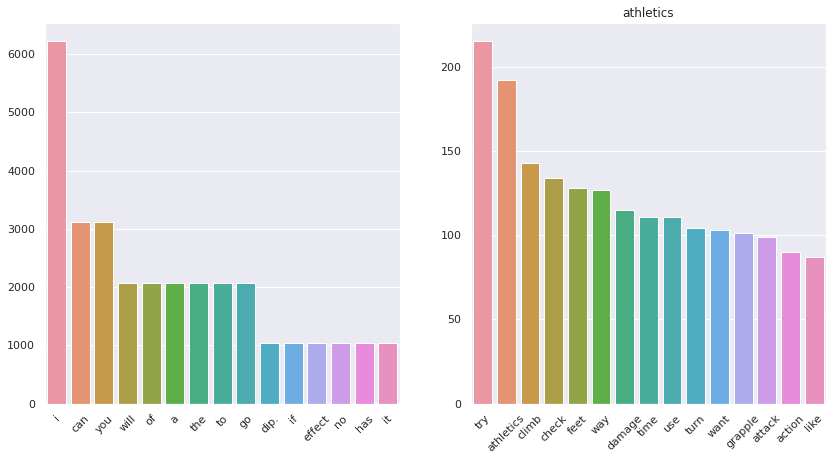

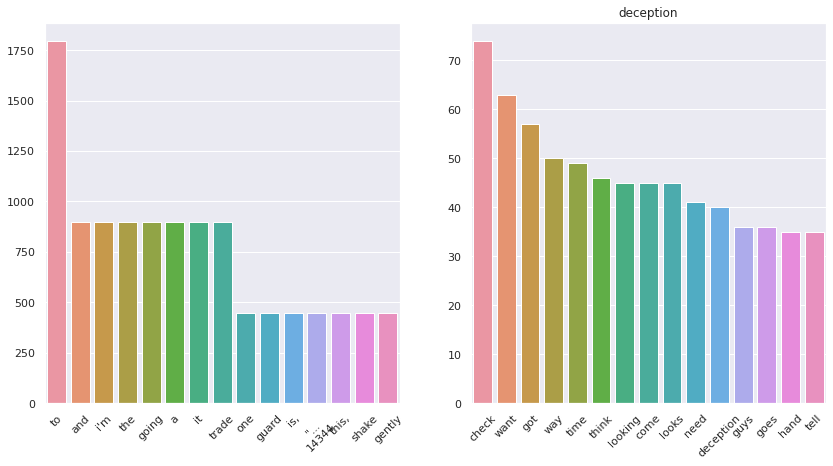

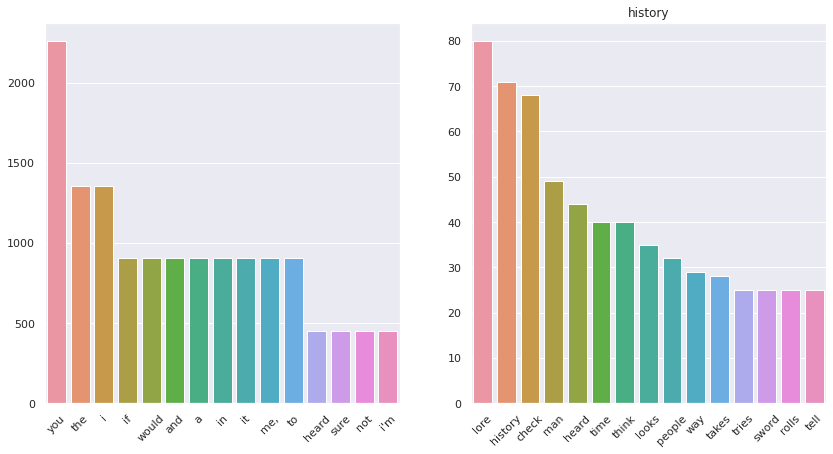

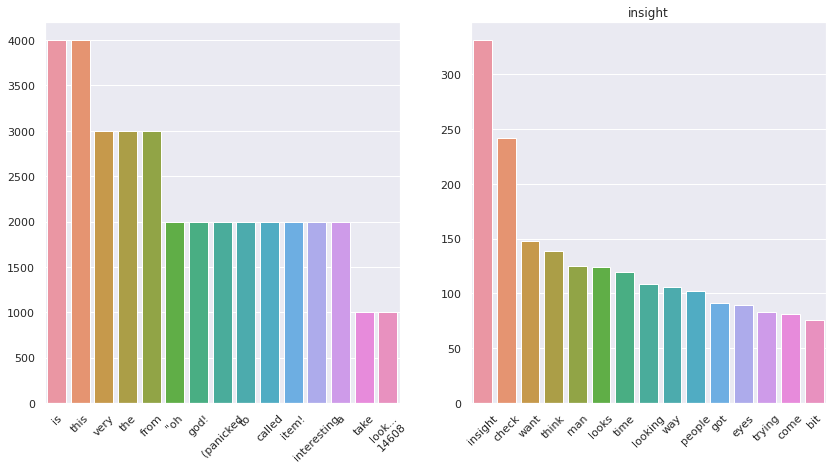

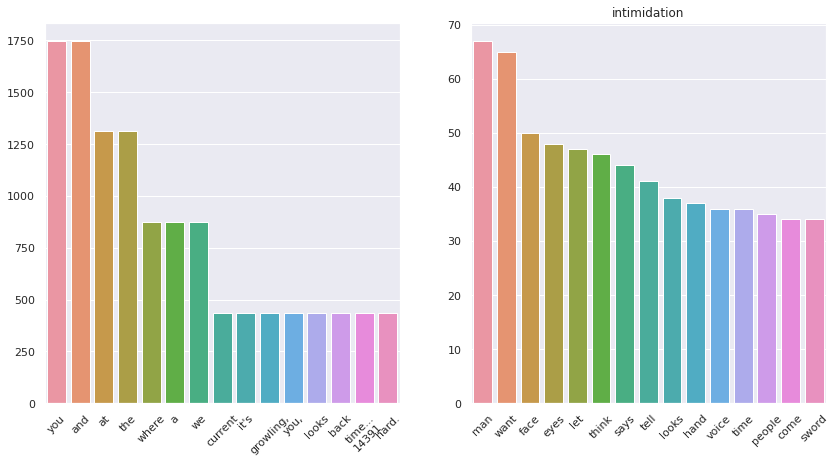

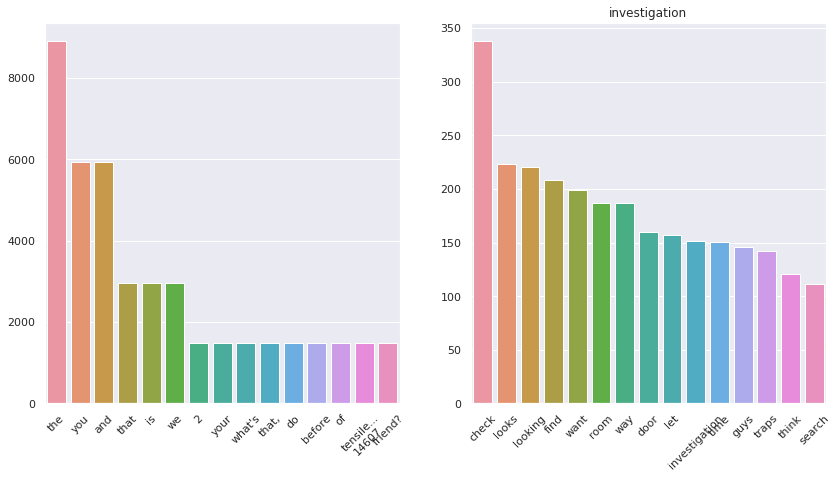

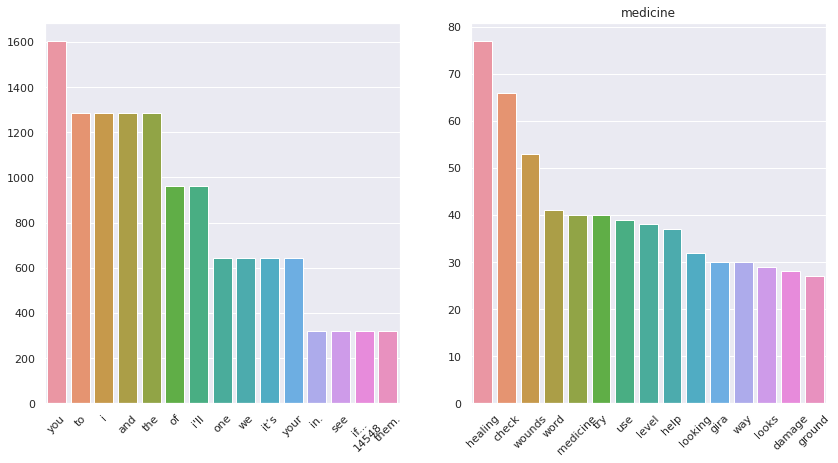

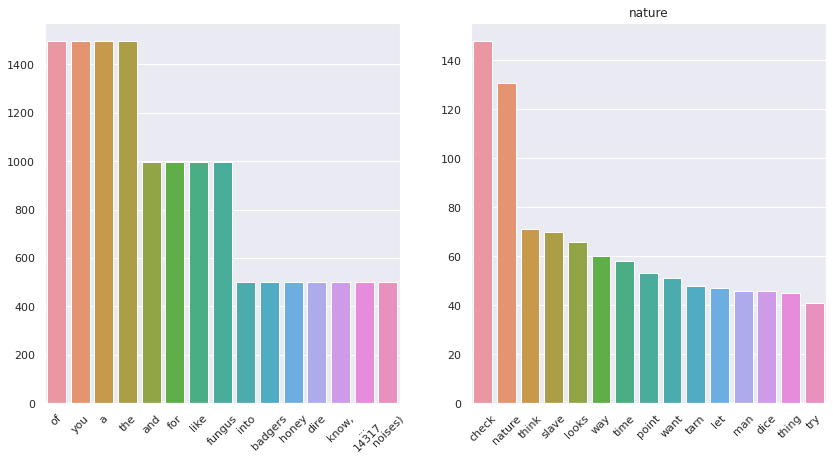

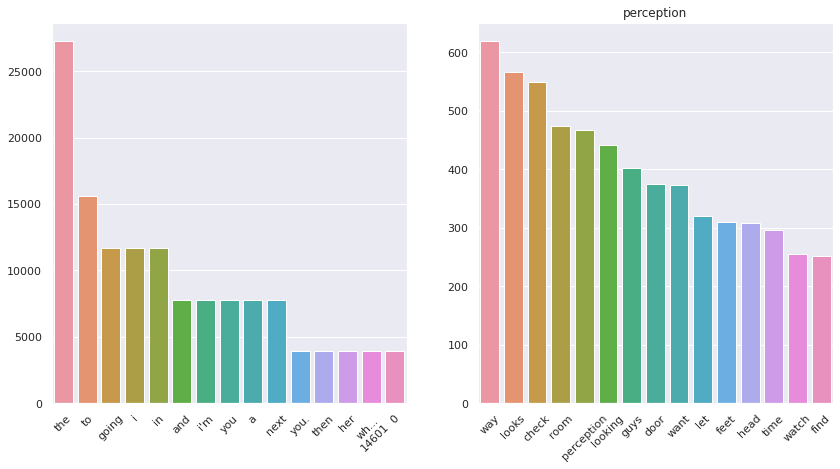

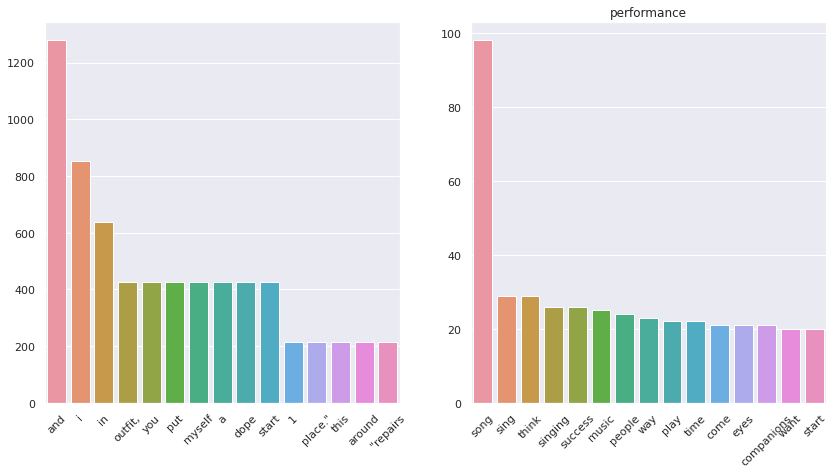

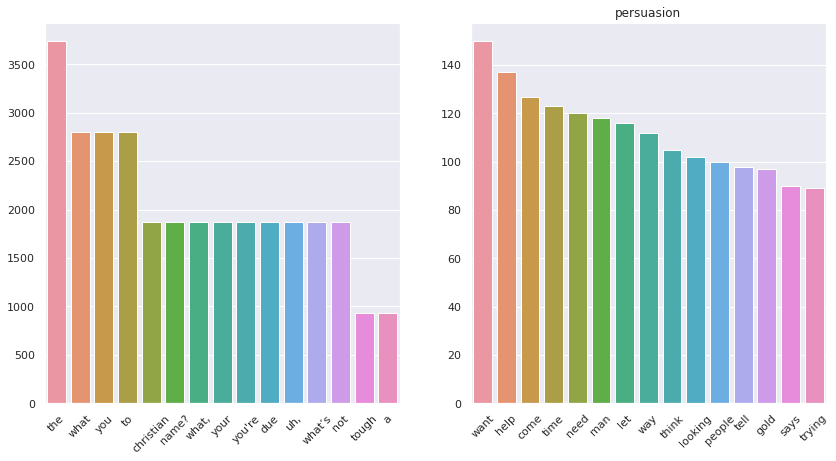

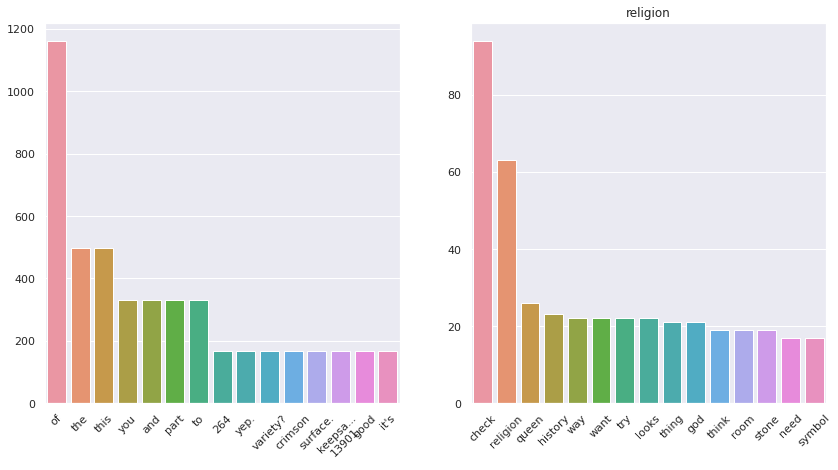

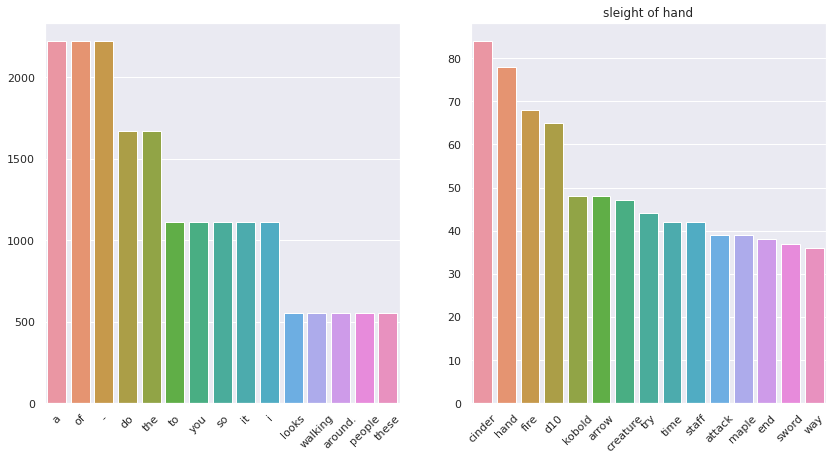

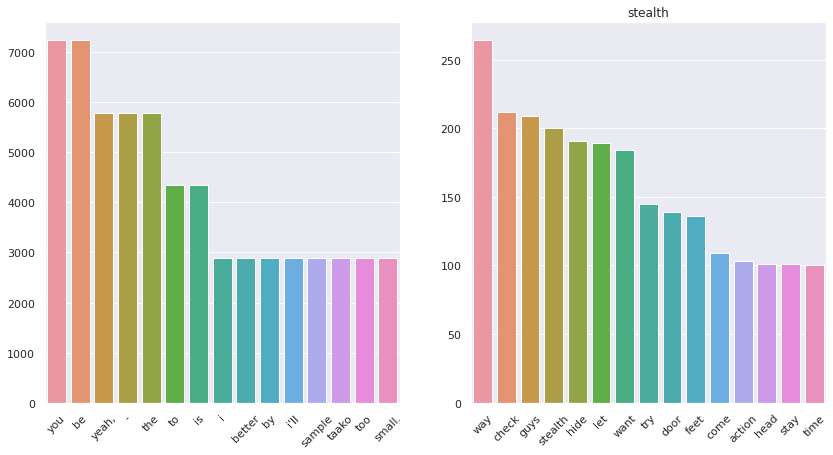

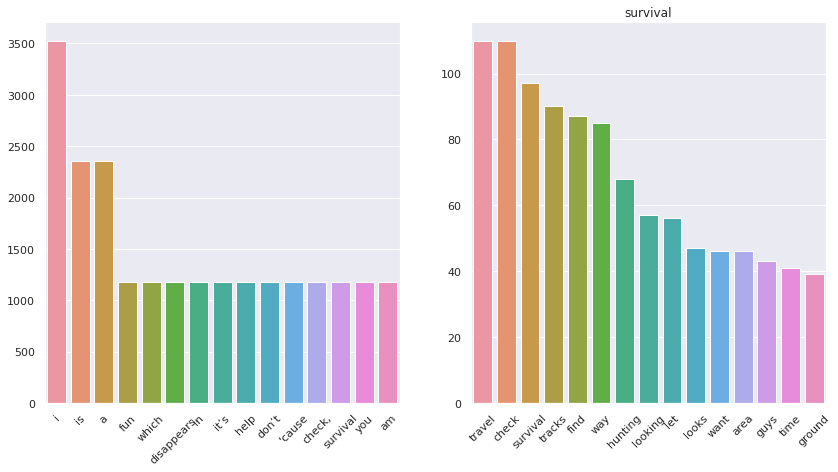

In [241]:
nlp_vs_ordinary(concatenated_df)

In [243]:
concatenated_df

,skill,backward_text,filtered_words
0,perception,going weekly for the rest of the experimental ...,"[rest, arcs, starting, week, guess, episode, h..."
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
4,perception,play in the nfl!” and he was like “no.” there’...,"[play, nfl, like, idea, chosen, crosstalk, thank]"
...,...,...,...
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."
14614,stealth,i was under the assumption that you had to be ...,"[assumption, rolo, level, bath, house, house, ..."


In [288]:
dicionario = concatenated_df['filtered_words'].apply(lambda x: ' '.join(x)).tolist()
dicionario

['logic mean wanna help inhaling teeth ssssssssssssss logic pulling sun',
 'success open repercussions reper help exposing danger',
 'success open repercussions reper help exposing danger',
 'dealing consequences spellcasting rolled',
 'mark experience want failed crosstalk think way crosstalk',
 'leaning shooting snake length body heading water slides',
 'think information need gon investigate mystery rolls shit job dad',
 'trying wait thing think hiding choice choice hide pressure laughing hide bed',
 'love mark luck spent luck wanna line line aubrey fuego bastard',
 'services offer forestry service swimmer clothes duck',
 'rites omec companions guys expect receive healing care temple shrine established presence omec faith',
 'rage wants minute song thinking lines slaying protecting guidance got adventuring',
 'offered gold pieces mean boss lot money',
 'object maneuvering device action discretion action',
 'feet wagon magnus leap feet',
 'throw woods branches rustling throw axe dire

In [289]:
# # Call NLP pre processing
# clean_text = self.NLP_pp.preprocess(corpus)
# BOW and TFIDF, term must appear at least a number of times, limit max features and use ngrams
tfidf_vec = TfidfVectorizer(analyzer = 'word', max_df = 0.90, min_df = 3, ngram_range=(1, 2))
        
# Build dictionary to be able to use after training
tfidf_vec = tfidf_vec.fit(dicionario)
        
# Get counts on terms
bow_tfidf = tfidf_vec.transform(dicionario)

In [291]:
bow_tfidf.shape

(10718, 16704)

In [293]:
X_train, X_test, y_train, y_test = train_test_split(bow_tfidf, concatenated_df['skill'], test_size=0.3, random_state = 42)

In [285]:
X_train.shape

(7502, 16704)

In [260]:
X_test.shape

(4385, 23883)

In [259]:
y_train.shape

(10231,)

In [294]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [295]:
y_pred = clf.predict(X_test)

In [296]:
confusion_matrix(y_test, y_pred)

array([[ 32,   2,   0,  50,   2,   0,   1,   0,  24,   1,   1,   1,   4,
          0,   9,  28,   1],
       [  2,   6,   1,   6,   0,   1,   1,   1,   9,   0,   0,   1,   1,
          0,   1,   5,   0],
       [  0,   2,  39,  19,   2,   5,   7,   1,  50,   2,   7,   1,   8,
          2,   1,   6,   1],
       [  7,   0,   1, 186,   0,   3,   5,   4,  33,   3,   5,   3,   6,
          0,  13,  28,   6],
       [  0,   1,   0,  14,  11,   5,  16,   1,  30,   0,   1,   1,  24,
          0,   2,  22,   1],
       [  1,   0,   4,  15,   0,  42,   5,   4,  25,   1,   1,   2,  12,
          0,   5,  10,   6],
       [  2,   0,   4,   8,   5,   3, 118,   2,  67,   1,   1,   3,  29,
          0,   8,  24,   2],
       [  0,   1,   1,  18,   0,   5,  12,  32,  27,   1,   1,   0,  25,
          0,   9,  15,   0],
       [  6,   2,  12,  38,   0,   1,  15,   3, 271,   5,   5,   3,  13,
          2,   5,  49,  12],
       [  0,   0,   1,  12,   0,   1,   3,   3,  25,  47,   3,   1,   2,
         

In [269]:
def plot_confusion_matrix(lst_skills, title, reals, predictions):
        ax = plt.axes()
        sns.heatmap(confusion_matrix(reals, predictions), xticklabels=lst_skills, yticklabels=lst_skills, ax=ax)
        ax.set_title(title)
        ax.set_ylabel('Real')
        ax.set_xlabel('Predicted')

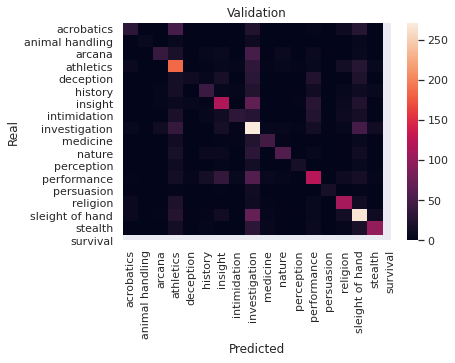

In [297]:
plot_confusion_matrix(skill_list, 'Validation', y_test, y_pred)

In [298]:
concatenated_df['skill'].value_counts()

investigation      1485
stealth            1447
athletics          1037
insight             999
persuasion          935
survival            588
sleight of hand     556
acrobatics          506
nature              499
arcana              484
history             452
deception           449
intimidation        437
medicine            321
performance         213
religion            166
animal handling     144
Name: skill, dtype: int64

In [280]:
concatenated_df = concatenated_df.loc[concatenated_df["skill"] != "perception"]
concatenated_df

,skill,backward_text,filtered_words
1,performance,"by, like, logic, you know what i mean? so i ca...","[logic, mean, wanna, help, inhaling, teeth, ss..."
2,investigation,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
3,insight,"success, you open yourself up to repercussions...","[success, open, repercussions, reper, help, ex..."
5,medicine,you are dealing with the consequences of your ...,"[dealing, consequences, spellcasting, rolled]"
7,stealth,"no. yeah, so go ahead and mark experience. yes...","[mark, experience, want, failed, crosstalk, th..."
...,...,...,...
14610,investigation,"anything else interesting in the room, outside...","[room, bodies, bodies, looks, bits, furniture,..."
14611,investigation,(laughter) (sings) continuity. roll for contin...,"[laughter, sings, continuity, continuity, beau..."
14612,insight,"wall. there is a very, very faint scratch into...","[wall, scratch, says, referring, says, money, ..."
14613,deception,advice from when it comes to administrating my...,"[advice, comes, administrating, people, punch,..."


In [300]:
def data_leveler(df, lst_skills, min_obs):
    df_sample = pd.DataFrame() 
    for skill in lst_skills:
        # Get number of observations for skill
        num_obs = sum(df['skill'].values == skill)
        
        # Make a more homogeneous dataset for training
        if num_obs > min_obs:
            # If skill has more than min_obs, get a sample
            df_skill = df[df['skill'].values == skill].sample(n = min_obs).reset_index(drop=True)
        else:
            # If skill has less than min_obs, do an oversample
            df_skill = df[df['skill'].values == skill].sample(n = min_obs, replace=True).reset_index(drop=True)
        df_sample = df_sample.append(df_skill).reset_index(drop=True)  
    return df_sample

In [305]:
sample_df = data_leveler(concatenated_df, skill_list, 600)

In [306]:
sample_dict = sample_df['filtered_words'].apply(lambda x: ' '.join(x)).tolist()
sample_dict

['caverns getting laugh clarota shuffles guys getting slap let wanted lack oxygen grog morning feel christ sake guys walking chatter discussions like',
 'jostling spell time thorbir jumping platform eagle eagle form keyleth catches plummeting goes eagle form gliding issue tiberius falling want guys tiberius thorbir vax kash dexterity saving throws tell fall carpet want try pull carpet land shit',
 'carpet way trial jumping plank landed plank point',
 'kind thing banned ravnica opinion andrew guildpact',
 'cues indicators vanished mac hud panel left cascade cherry signal warnings lit sensor inputs fell dominoes squinting static choked viewscreen macarthur located metal glass sensor array ground mech foot captain got sensor malfunction nelson drawled boys check killed snow blew gusts hud looked mutara nebula supposed dance minefield shit thank macarthur engaged vulcan energy shield coils lodged mech began hum buzz seat mac vibrated energy hairs nape neck pricked threw titan weight pumped

In [307]:
# # Call NLP pre processing
# clean_text = self.NLP_pp.preprocess(corpus)
# BOW and TFIDF, term must appear at least a number of times, limit max features and use ngrams
tfidf_vec = TfidfVectorizer(analyzer = 'word', max_df = 0.90, min_df = 3, ngram_range=(1, 2))
        
# Build dictionary to be able to use after training
tfidf_vec = tfidf_vec.fit(sample_dict)
        
# Get counts on terms
bow_tfidf = tfidf_vec.transform(sample_dict)

In [308]:
X_train, X_test, y_train, y_test = train_test_split(bow_tfidf, sample_df['skill'], test_size=0.3, random_state = 42)

In [309]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [310]:
y_pred = clf.predict(X_test)

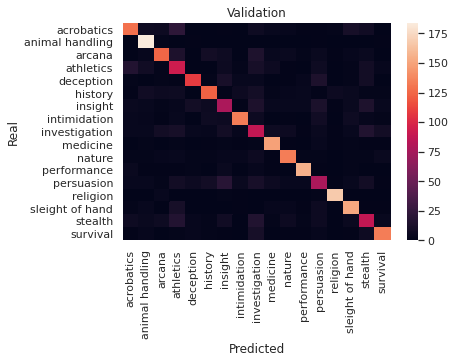

In [311]:
plot_confusion_matrix(skill_list, 'Validation', y_test, y_pred)

# Podcast

In [4]:
# Transforma os dados do csv em um dataframe
podcast_df = pd.read_csv(podcast_file)

In [5]:
# Substitui espaços em branco por NaN
podcast_df = podcast_df.replace(r'^\s*$', np.NaN, regex=True)
# Vertifica número de linhas nulas para cada coluna do arquivo
podcast_df.isnull().sum()

skill            0
backward_text    0
check_line       0
original_name    0
dtype: int64

In [6]:
# Aplica uma função que limpa espaços em branco antes e depois da skill, além de passar para letra minúscula
podcast_df["skill"] = podcast_df["skill"].apply(lambda x: x.strip().lower())

# Agrupa e conta o número frases por skill, também coloca as skills em ordem alfabética 
podcast_pps = podcast_df.groupby(by="skill", sort=True).count()['backward_text']
podcast_pps

skill
acrobatics          82
animal handling     47
arcana             103
athletics          137
concentration        1
deception          105
disguise             3
history             42
insight             87
intimidation        42
investigation      204
medicine            41
nature              49
perception         405
performance         77
persuasion          63
religion            15
sleight of hand     41
stealth            125
survival            64
Name: backward_text, dtype: int64

In [7]:
podcast_pps["persuasion"]

63

# Skills

In [3]:
# Transforma os dados do csv em um dataframe
skills_df = pd.read_csv(skills_file, usecols=["skill", "backward_text"])
skills_df

,skill,backward_text
0,History,"> nodded accepting the parcel by ’s hands, in ..."
1,Performance,"> nodded accepting the parcel by ’s hands, in ..."
2,Arcana,">""Aye, give me but a moment to study this piec..."
3,Medicine,>(Healing roll: to see if he can remember anyt...
4,Survival,>(OOC: Travel roll. Do we need even to test co...
...,...,...
49800,Survival,"The great beast leaps through the camp, pierc..."
49801,Perception,As the darkness surrounds and your feeble fir...
49802,Stealth,[OOC: For anyone new to TOR or unfamiliar wit...
49803,Perception,[OOC: For anyone new to TOR or unfamiliar wit...


In [9]:
# Substitui os campos com espaço em branco por NaN
skills_df = skills_df.replace(r'^\s*$', np.NaN, regex=True)
# Vertifica número de linhas nulas para cada coluna do arquivo
skills_df.isnull().sum()

skill             54
backward_text      0
original_name    155
dtype: int64

In [10]:
# Lista linhas que estão com NaN no campo skill
skills_df.loc[skills_df["skill"].isnull()]

,skill,backward_text,original_name
7692,NaN,>The remaining trio of Goblins immediately lau...,#4
7693,NaN,>The remaining trio of Goblins immediately lau...,#5
7694,NaN,>The remaining trio of Goblins immediately lau...,#6
9958,NaN,>Sticks bound off scale and fists find only ai...,12)
9961,NaN,>Sticks bound off scale and fists find only ai...,12)
9964,NaN,>Sticks bound off scale and fists find only ai...,10)
9967,NaN,>Sticks bound off scale and fists find only ai...,10)
10064,NaN,> Medicus #2,(13)
10080,NaN,>Vigilance,10
10117,NaN,>Vigilant,10-1=9


In [11]:
# Remove todas as linhas com NaN no campo skill
skill_df = skills_df.dropna(subset=["skill"], inplace=True)
# Soma as linhas com NaN no campo skill
skills_df["skill"].isnull().sum()

0

In [12]:
# Aplica uma função que transforma o campo em string,
# limpa espaços em branco antes e depois da string, além de passar para letra minúscula
skills_df["skill"] = skills_df["skill"].apply(lambda x: str(x).strip().lower())
skills_df

,skill,backward_text,original_name
0,history,"> nodded accepting the parcel by ’s hands, in ...",Lore
1,performance,"> nodded accepting the parcel by ’s hands, in ...",Song
2,arcana,">""Aye, give me but a moment to study this piec...",Craft
3,medicine,>(Healing roll: to see if he can remember anyt...,Healing
4,survival,>(OOC: Travel roll. Do we need even to test co...,Travel
...,...,...,...
49800,survival,"The great beast leaps through the camp, pierc...",Hunting
49801,perception,As the darkness surrounds and your feeble fir...,Awareness
49802,stealth,[OOC: For anyone new to TOR or unfamiliar wit...,Stealth
49803,perception,[OOC: For anyone new to TOR or unfamiliar wit...,Awareness


In [13]:
# Agrupa e conta o número frases por skill, além de colocar em ordem alfabética de skill.
skills_pps = skills_df.groupby(by="skill", sort=True).count()["backward_text"]
skills_pps

skill
#1 atk                  14
#2                       1
#2 atk                  15
#3 atk                  11
#4 atk                   4
                        ..
​hit 61                  3
​insight check           1
​opportunity attack      1
​str                     1
​willpower hard  @30     1
Name: backward_text, Length: 9307, dtype: int64

In [14]:
skills_pps["persuasion"]

540

# CR skills

In [15]:
# Transforma os dados do csv em um dataframe
CR_df = pd.read_csv(CR_file)

In [16]:
# Substitui campos com espaço em branco por NaN
CR_df = CR_df.replace(r'^\s*$', np.NaN, regex=True)
# Vertifica número de linhas nulas para cada coluna do arquivo
CR_df.isnull().sum()

skill            0
backward_text    0
check_line       0
dtype: int64

In [17]:
# Aplica uma função que limpa espaços em branco antes e depois da skill, além de passar para letra minúscula
CR_df['skill'] = CR_df['skill'].apply(lambda x: x.strip().lower())
CR_df

,skill,backward_text,check_line
0,persuasion,‘Cause the dwarves weren't fans of nobody with...,and rolled pretty damn well on a persuasion ch...
1,persuasion,Careful. (sighs) Not as often as I get woken u...,Matt: Make a persuasion roll.
2,persuasion,You're so… we just heard you're so… impressive...,Matt: (To Marisha) Make a persuasion check.
3,persuasion,"they're terrible people. Anyway, my associates...",Matt: Make a persuasion roll. You can assist i...
4,persuasion,"Anyway, my associates and I were wondering if ...",Taliesin: I'm assisting in this persuasion rol...
...,...,...,...
5249,investigation,(laughter) (sings) Continuity. Roll for contin...,investigation check.
5250,insight,"wall. There is a very, very faint scratch into...",TRAVIS: Insight check.
5251,deception,advice from when it comes to administrating my...,MATT: Make a deception check.
5252,stealth,I was under the assumption that you had to be ...,MATT: Okay. Go ahead and make a stealth check.


In [18]:
# Agrupa e conta o número frases por skill, também coloca as skills em ordem alfabética 
# PPS = phrases per skill
CR_pps = CR_df.loc[: , ["skill"]]
CR_pps['frequency'] = CR_pps.groupby('skill')['skill'].transform('count')
CR_pps =  CR_pps.drop_duplicates()
# CR_df.groupby(by="skill", sort=True).count()
# CR_pps = Counter(CR_df["skill"])
CR_pps

,skill,frequency
0,persuasion,333
6,perception,1431
7,insight,445
10,intimidation,111
12,stealth,609
13,acrobatics,236
15,performance,44
21,sleight of hand,57
26,athletics,371
58,nature,183


In [19]:
CR_pps["persuasion"]

KeyError: 'persuasion'

# Tabela total

In [20]:
# Dataframe resultado da concatenação dos três dataframes
concatenated_df = pd.concat([podcast_df,skills_df,CR_df])

In [21]:
# Agrupa e conta o número frases por skill, também coloca as skills em ordem alfabética 
total_pps = concatenated_df.groupby("skill", sort=True).count()['backward_text']
total_pps

skill
#1 atk                  14
#2                       1
#2 atk                  15
#3 atk                  11
#4 atk                   4
                        ..
​hit 61                  3
​insight check           1
​opportunity attack      1
​str                     1
​willpower hard  @30     1
Name: backward_text, Length: 9307, dtype: int64

In [22]:
total_pps["persuasion"]

936

In [23]:
"""
    Função que transforma uma lista de palavras bem formatadas em um dicionário de ocorrências.
    Ex.:
        > x = ['Philipe', 'Jc', 'Victor', 'Philipe', 'Jc', 'Victor', 'Victor', 'Jc']
        > ocorrencias(x)
        > {'Philipe': 2, 'Jc': 3, 'Victor': 3}
"""
def ocorrencias(lista):
    dict_ocorrencias = {}
    for i in lista:
        if i in dict_ocorrencias:
            dict_ocorrencias[i] += 1
        else:
            dict_ocorrencias[i] = 1
    return dict_ocorrencias

In [25]:
total_pps_dict = total_pps.to_dict()
total_pps_dict

{'#1 atk': 14,
 '#2': 1,
 '#2 atk': 15,
 '#3 atk': 11,
 '#4 atk': 4,
 '-damage': 1,
 '1': 1,
 '1 dmg': 1,
 '1 to 4 silver darter 5 rabbit viper 6 the bad snake': 1,
 '15-12=16': 1,
 '16-12=17': 1,
 '1d20': 1,
 '1d6': 1,
 '1d61': 1,
 '2': 1,
 '2 dmg': 1,
 '3': 1,
 '3 dmg': 1,
 '3rd try': 1,
 '4': 1,
 '5 = volkbert': 1,
 '@26': 1,
 '_2nd_crit': 1,
 '_crit': 1,
 '_dodge': 1,
 '_extradamage': 1,
 '_parry': 1,
 'a': 3,
 'a  heavin   amp  a hoin': 1,
 'a  o    elixir of life': 1,
 'a  o    life elixir': 1,
 'a att': 3,
 'a bitter memory': 1,
 'a blip on my scope': 1,
 'a bold display': 1,
 'a d   to add modifiers to for whatever is needed here': 1,
 'a dam': 3,
 'a die': 14,
 'a die   wits': 1,
 'a die  wits and bonus': 1,
 'a disadvantage': 1,
 'a feinting guard': 1,
 'a good spine throttling': 1,
 'a init': 1,
 'a little extra whip tlc for': 1,
 'a mysterious die of fate': 1,
 'a or d damage': 1,
 'a paladin prepares initiative': 1,
 'a roll': 1,
 'a s': 4,
 'a savin  the boat driver': 1,


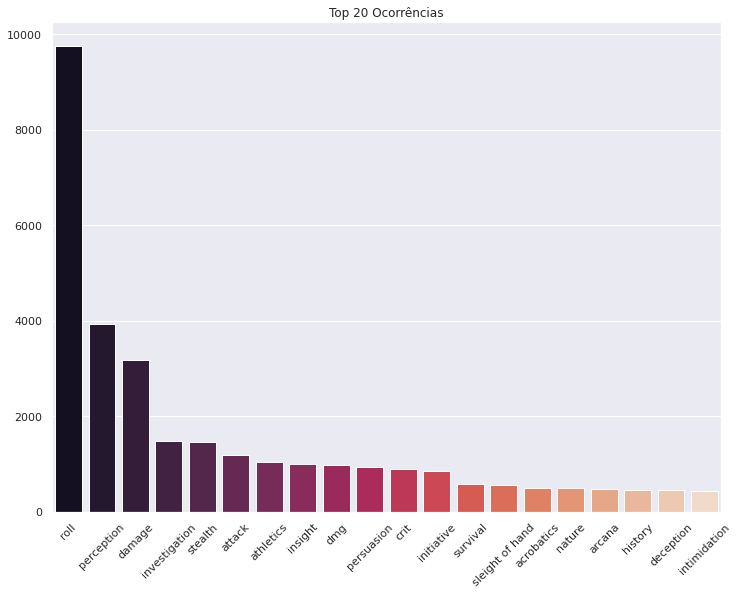

In [26]:
# Total set
bar_graphic(dicionario = total_pps_dict, max=20)

In [27]:
# CR Set
CR_pps_dict = CR_pps.to_dict()
bar_graphic(dicionario=CR_pps_dict, paleta="mako", max=18)

TypeError: '<' not supported between instances of 'dict' and 'dict'

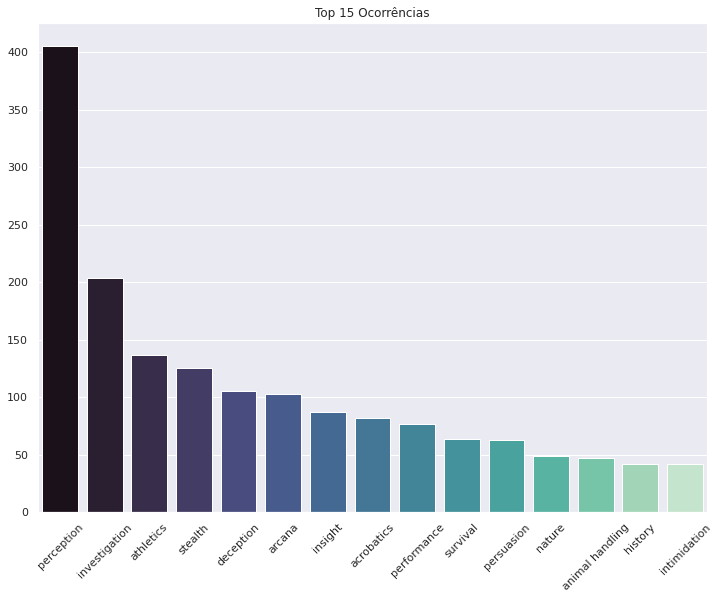

In [28]:
# Podcast set
podcast_pps_dict = podcast_pps.to_dict()
bar_graphic(dicionario = podcast_pps_dict, paleta="mako")

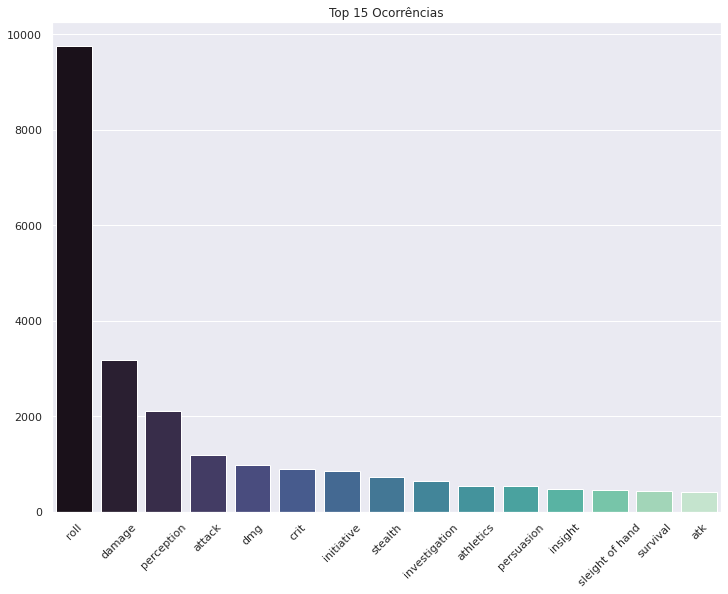

In [29]:
# Skills Set
skills_pps_dict = skills_pps.to_dict()
bar_graphic(dicionario = skills_pps_dict, paleta="mako")

# Total de Palavras do backward_text

In [30]:
# Transforma cada linha da coluna de frases do dataframe em lista cujos elementos 
# são as frases
list_df = list(concatenated_df["backward_text"])
# Separa a lista de frases em uma lista de lista de palavras
full_list = [i.split(" ") for i in list_df]
full_list

[['going',
  'weekly',
  'for',
  'the',
  'rest',
  'of',
  'the',
  'experimental',
  'arcs',
  '[',
  'Woohoo!]',
  'starting',
  'this',
  'week.',
  'So,',
  'um,',
  'I',
  'guess',
  'actually',
  'we',
  'have',
  'an',
  'episode—',
  'I',
  'hope',
  'we',
  'don’t',
  'screw',
  'it',
  'up!'],
 ['by,',
  'like,',
  'logic,',
  'you',
  'know',
  'what',
  'I',
  'mean?',
  'So',
  'I',
  'can’t',
  'be',
  'like,',
  '“I',
  'wanna',
  'Help',
  'Out',
  'by…”',
  '[inhaling',
  'sharply',
  'through',
  'teeth]',
  'Ssssssssssssss...',
  'Ooooh,',
  'logic.',
  '“...pulling',
  'the',
  'sun',
  'down.”',
  'Yeah.'],
 ['success,',
  'you',
  'open',
  'yourself',
  'up',
  'to',
  'repercussions.',
  'To,',
  'like,',
  'the',
  'same',
  'reper—',
  'so',
  'you',
  'can',
  'help',
  'out,',
  'yeah,',
  'but',
  'you',
  'are',
  'also',
  'exposing',
  'yourself',
  'to',
  'danger,',
  'which',
  'is',
  'real',
  'smart.'],
 ['success,',
  'you',
  'open',
  'yoursel

In [31]:
# Transforma uma lista de 2 dimensões em 1
flat_list = [item for sublist in full_list for item in sublist]
flat_list

['going',
 'weekly',
 'for',
 'the',
 'rest',
 'of',
 'the',
 'experimental',
 'arcs',
 '[',
 'Woohoo!]',
 'starting',
 'this',
 'week.',
 'So,',
 'um,',
 'I',
 'guess',
 'actually',
 'we',
 'have',
 'an',
 'episode—',
 'I',
 'hope',
 'we',
 'don’t',
 'screw',
 'it',
 'up!',
 'by,',
 'like,',
 'logic,',
 'you',
 'know',
 'what',
 'I',
 'mean?',
 'So',
 'I',
 'can’t',
 'be',
 'like,',
 '“I',
 'wanna',
 'Help',
 'Out',
 'by…”',
 '[inhaling',
 'sharply',
 'through',
 'teeth]',
 'Ssssssssssssss...',
 'Ooooh,',
 'logic.',
 '“...pulling',
 'the',
 'sun',
 'down.”',
 'Yeah.',
 'success,',
 'you',
 'open',
 'yourself',
 'up',
 'to',
 'repercussions.',
 'To,',
 'like,',
 'the',
 'same',
 'reper—',
 'so',
 'you',
 'can',
 'help',
 'out,',
 'yeah,',
 'but',
 'you',
 'are',
 'also',
 'exposing',
 'yourself',
 'to',
 'danger,',
 'which',
 'is',
 'real',
 'smart.',
 'success,',
 'you',
 'open',
 'yourself',
 'up',
 'to',
 'repercussions.',
 'To,',
 'like,',
 'the',
 'same',
 'reper—',
 'so',
 'you',

In [32]:
# Transforma tudo que não sejam números ou letras em string vazia, passa para letra minúscula
filtered_flat_list = [re.sub('[^A-Za-z0-9]+', '', i).lower() for i in flat_list]
# Remove as strings vazias da lista
filtered_flat_list = [x for x in filtered_flat_list if x]
filtered_flat_list

['going',
 'weekly',
 'for',
 'the',
 'rest',
 'of',
 'the',
 'experimental',
 'arcs',
 'woohoo',
 'starting',
 'this',
 'week',
 'so',
 'um',
 'i',
 'guess',
 'actually',
 'we',
 'have',
 'an',
 'episode',
 'i',
 'hope',
 'we',
 'dont',
 'screw',
 'it',
 'up',
 'by',
 'like',
 'logic',
 'you',
 'know',
 'what',
 'i',
 'mean',
 'so',
 'i',
 'cant',
 'be',
 'like',
 'i',
 'wanna',
 'help',
 'out',
 'by',
 'inhaling',
 'sharply',
 'through',
 'teeth',
 'ssssssssssssss',
 'ooooh',
 'logic',
 'pulling',
 'the',
 'sun',
 'down',
 'yeah',
 'success',
 'you',
 'open',
 'yourself',
 'up',
 'to',
 'repercussions',
 'to',
 'like',
 'the',
 'same',
 'reper',
 'so',
 'you',
 'can',
 'help',
 'out',
 'yeah',
 'but',
 'you',
 'are',
 'also',
 'exposing',
 'yourself',
 'to',
 'danger',
 'which',
 'is',
 'real',
 'smart',
 'success',
 'you',
 'open',
 'yourself',
 'up',
 'to',
 'repercussions',
 'to',
 'like',
 'the',
 'same',
 'reper',
 'so',
 'you',
 'can',
 'help',
 'out',
 'yeah',
 'but',
 'you',


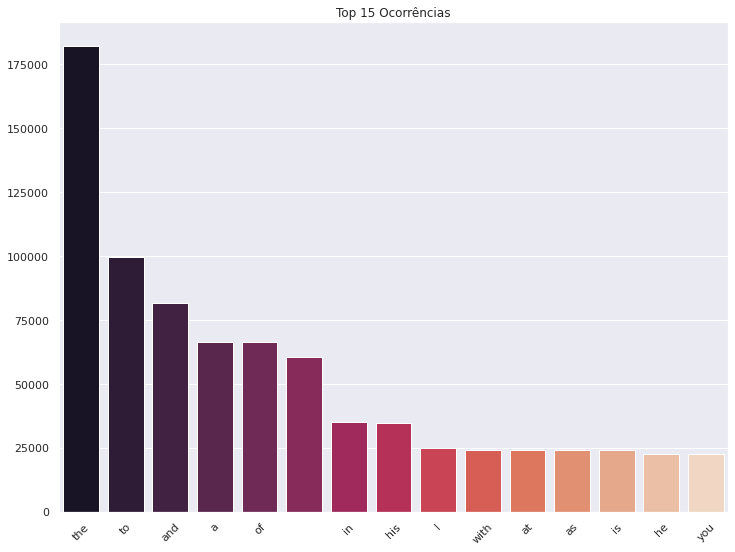

In [33]:
bar_graphic(lista_ocorrencias = flat_list)

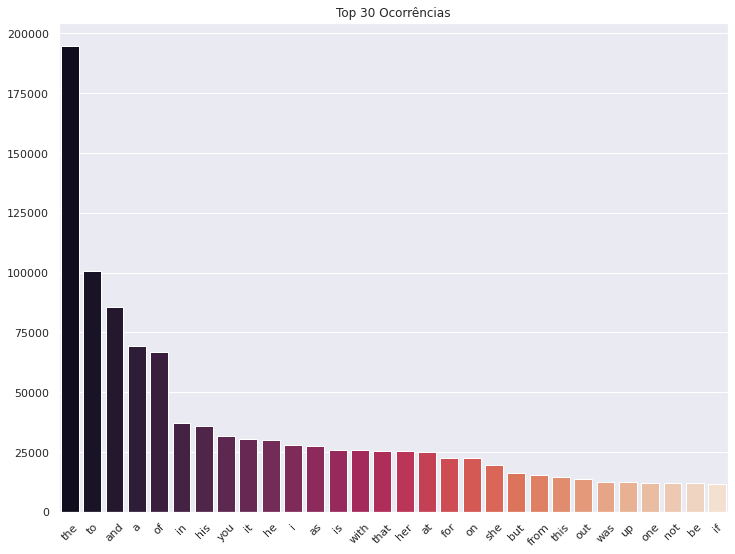

In [34]:
bar_graphic(lista_ocorrencias = filtered_flat_list, max=30)

In [35]:
list_slice = list_df[0:11]
list_slice

['going weekly for the rest of the experimental arcs [ Woohoo!] starting this week. So, um, I guess actually we have an episode— I hope we don’t screw it up!',
 'by, like, logic, you know what I mean? So I can’t be like, “I wanna Help Out by…” [inhaling sharply through teeth] Ssssssssssssss... Ooooh, logic. “...pulling the sun down.” Yeah.',
 'success, you open yourself up to repercussions. To, like, the same reper— so you can help out, yeah, but you are also exposing yourself to danger, which is real smart.',
 'success, you open yourself up to repercussions. To, like, the same reper— so you can help out, yeah, but you are also exposing yourself to danger, which is real smart.',
 'play in the NFL!” and he was like “No.” There’s some really- we haven’t— I really like this idea of a Chosen that’s just like [crosstalk] “No, no thank you!”',
 'you are dealing with the consequences of your own spellcasting. That’s definitely this. Um. Yeah so- but if it’s Weird, I rolled an eight plus two s

In [36]:
doc = nlp(list_slice[0])
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

going go VERB VBG ROOT xxxx True False
weekly weekly ADV RB advmod xxxx True False
for for ADP IN prep xxx True True
the the DET DT det xxx True True
rest rest NOUN NN pobj xxxx True False
of of ADP IN prep xx True True
the the DET DT det xxx True True
experimental experimental ADJ JJ amod xxxx True False
arcs arc NOUN NNS pobj xxxx True False
[ [ PUNCT -LRB- punct [ False False
Woohoo Woohoo PROPN NNP npadvmod Xxxxx True False
! ! PUNCT . punct ! False False
] ] PUNCT -RRB- punct ] False False
starting start VERB VBG advcl xxxx True False
this this DET DT det xxxx True True
week week NOUN NN npadvmod xxxx True False
. . PUNCT . punct . False False
So so ADV RB advmod Xx True True
, , PUNCT , punct , False False
um um INTJ UH intj xx True False
, , PUNCT , punct , False False
I I PRON PRP nsubj X True True
guess guess VERB VBP ROOT xxxx True False
actually actually ADV RB advmod xxxx True False
we we PRON PRP nsubj xx True True
have have VERB VBP ccomp xxxx True True
an an DET DT det x

In [37]:
for token in doc:
    if not token.is_stop and token.pos_ in ("VERB", "NOUN"):
        print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
                token.shape_, token.is_alpha, token.is_stop)

going go VERB VBG ROOT xxxx True False
rest rest NOUN NN pobj xxxx True False
arcs arc NOUN NNS pobj xxxx True False
starting start VERB VBG advcl xxxx True False
week week NOUN NN npadvmod xxxx True False
guess guess VERB VBP ROOT xxxx True False
episode episode NOUN NN dobj xxxx True False
hope hope VERB VBP ccomp xxxx True False
screw screw VERB VB ccomp xxxx True False


In [38]:
len(list_df)

56738

In [42]:
result_list = []
for i in list_df:
    doc = nlp(i)
    result_list_element = []
    for token in doc:
        if not token.is_stop and token.pos_ in ("VERB", "NOUN"):
            result_list_element.append(token.text)
    result_list.append(result_list_element)

In [46]:
result_list[0]

['going',
 'rest',
 'arcs',
 'starting',
 'week',
 'guess',
 'episode',
 'hope',
 'screw']

In [47]:
bar_graphic(lista_ocorrencias = result_list, max=30)

TypeError: unhashable type: 'list'

In [41]:
skill_list = list(CR_df['skill'].unique())

In [42]:
skill_text_df = concatenated_df.loc[:,["skill", "backward_text"]]
skill_text_df

,skill,backward_text
0,perception,going weekly for the rest of the experimental ...
1,performance,"by, like, logic, you know what I mean? So I ca..."
2,investigation,"success, you open yourself up to repercussions..."
3,insight,"success, you open yourself up to repercussions..."
4,perception,play in the NFL!” and he was like “No.” There’...
...,...,...
5249,investigation,(laughter) (sings) Continuity. Roll for contin...
5250,insight,"wall. There is a very, very faint scratch into..."
5251,deception,advice from when it comes to administrating my...
5252,stealth,I was under the assumption that you had to be ...


In [169]:
for skill in skill_list:
    flat_list = [item for sublist in skill_text_groupby[skill] for item in sublist]
    bar_graphic(lista_ocorrencias=flat_list, title=skill, dim=(8,6))
    wordcloud(' '.join(flat_list))

NameError: name 'skill_text_groupby' is not defined